In [ ]:
%pip install langchain langchain_core langchain_community tavily-python
%pip install langgraph langchain-ollama python-dotenv

In [ ]:
import requests
import os
from langchain.tools import tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_ollama import ChatOllama

from dotenv import load_dotenv

load_dotenv() 
api_key = os.getenv("SPORT_api_key")
api_secret = os.getenv("SPORT_api_secret")

In [18]:
class FootballData:
    """
    This is a class for retrieving  football upcoming matches based on country name.
    """
    def __init__(self):
        self.BASE_URL = "https://livescore-api.com/api-client"
        self.api_key = api_key
        self.api_secret = api_secret
    
    def get_country_id(self, country_name):
        """Fetch country ID by country name."""
        url = f"{self.BASE_URL}/countries/list.json?key={self.api_key}&secret={self.api_secret}"
        response = requests.get(url).json()
        
        for country in response["data"]["country"]:
            if country["name"].lower() == country_name.lower():
                return country["id"]
        return None

    def get_competition_ids(self, country_id):
        """Fetch competition IDs for a given country ID."""
        url = f"{self.BASE_URL}/competitions/list.json?key={self.api_key}&secret={self.api_secret}&country_id={country_id}"
        response = requests.get(url).json()
        
        return [comp["id"] for comp in response["data"]["competition"]]

    def get_upcoming_fixtures(self, competition_ids):
        """Fetch upcoming matches for given competition IDs"""
        fixtures = []
        
        for comp_id in competition_ids:
            url = f"{self.BASE_URL}/fixtures/matches.json?key={self.api_key}&secret={self.api_secret}&competition_id={comp_id}"
            response = requests.get(url).json()
            
            if "fixtures" in response["data"]:
                fixtures.extend(response["data"]["fixtures"])
        
        return fixtures

    def get_upcoming_matches(self, country_name):
        """Get all upcoming matches and preprocess to take the information needed from result"""
        country_id = self.get_country_id(country_name)
        if not country_id:
            return f"No country found with the name {country_name}"

        competition_ids = self.get_competition_ids(country_id)
        if not competition_ids:
            return f"No competitions found for {country_name}"

        fixtures = self.get_upcoming_fixtures(competition_ids)
        if not fixtures:
            return f"No upcoming fixtures found for {country_name}"
        
        # Format the matches data
        formatted_matches = []
        for match in fixtures:
            formatted_matches.append(
                f"{match['home_name']} vs {match['away_name']} at {match['location']} - {match['date']}, {match['time']}"
        )
        return formatted_matches

In [19]:
@tool
def get_upcoming_matches(query:str):
    """Use this tool to get upcoming football matches for a given country. Provide the country name as the input."""
    sport_tool = FootballData()
    return sport_tool.get_upcoming_matches(query)

In [20]:
web_search = TavilySearchResults()

In [21]:
tools = [get_upcoming_matches, web_search]

In [ ]:
memory = MemorySaver()
model = ChatOllama(model="llama3.2:3b")

agent = create_react_agent(model, tools=tools, checkpointer=memory)

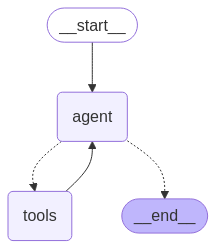

In [28]:
display(
    Image(agent.get_graph().draw_mermaid_png())
)

In [24]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages":[
        (
            "human",
            "Search for all upcoming matches in England"
        )
    ]
}

In [25]:
result = agent.stream(inputs, config=config, stream_mode="values")

In [26]:
for result in result:
    message = result["messages"][-1]
    message.pretty_print()

================================ Human Message =================================

Search for all upcoming matches in England
================================== Ai Message ==================================
Tool Calls:
  get_upcoming_matches (call_0VGztmqIXSsRuQLSZckWEy4B)
 Call ID: call_0VGztmqIXSsRuQLSZckWEy4B
  Args:
    query: England
================================= Tool Message =================================
Name: get_upcoming_matches

["Blackburn Rovers vs Sheffield Wednesday at Ewood Park - 2025-04-08, 18:45:00", "Bristol City vs West Bromwich Albion at Ashton Gate Stadium - 2025-04-08, 18:45:00", "Norwich City vs Sunderland at Carrow Road - 2025-04-08, 18:45:00", "Preston North End vs Cardiff City at Deepdale Stadium - 2025-04-08, 18:45:00", "Sheffield United vs Millwall at Bramall Lane - 2025-04-08, 18:45:00", "Stoke City vs Luton Town at Bet365 Stadium - 2025-04-08, 18:45:00", "Watford vs Hull City at Vicarage Road Stadium - 2025-04-08, 18:45:00", "Derby County vs Burnley

In [29]:
config = {"configurable": {"thread_id": "1"}}

inputs = {
    "messages":[
        (
            "human",
            "Search for top 10 foods in Italy"
        )
    ]
}

In [30]:
result = agent.stream(inputs, config=config, stream_mode="values")

In [31]:
for result in result:
    message = result["messages"][-1]
    message.pretty_print()

================================ Human Message =================================

Search for top 10 foods in Italy
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (2cfeec35-7eb6-4add-97fb-bf68ac1028a4)
 Call ID: 2cfeec35-7eb6-4add-97fb-bf68ac1028a4
  Args:
    query: top 10 foods in Italy
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.goaheadtours.com/travel-blog/articles/best-italian-dishes-worth-the-flight", "content": "Where to get the best cacio e pepe in Italy:\n\n\n\n10. Orecchiette with broccoli rabe\n\nOrigin: Puglia\n\nSay it in Italian: Orecchiette con cime di rapa\n\nWhen talking about the best Italian dishes, we were sure not to leave the country’s boot heel out. Here in the Puglia region, the sea (and fresh seafood) is just a stone’s throw away, there’s a rich farming tradition, and chef’s rely on a mode of cook